In [1]:
!CUDA_LAUNCH_BLOCKING=1

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [3]:
import sys
sys.path.append("..")

import pathlib
from tqdm import tqdm
from itertools import islice
from collections import defaultdict

import torch.multiprocessing as mp
mp.set_start_method('spawn')
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from src.utils import project_root
from src.data.free_spoken_digits import FreeSpokenDigits, SqueezeformerFeaturizer, SqueezeformerCollator


In [4]:
from matplotlib import pyplot as plt

In [5]:

dataset = FreeSpokenDigits(
    project_root()/"data/free_spoken_digits/free-spoken-digit-dataset-master"
)

train_ratio = 0.9
train_size = int(len(dataset) * train_ratio)
validation_size = len(dataset) - train_size

indexes = torch.randperm(len(dataset))
train_indexes = indexes[:train_size]
validation_indexes = indexes[train_size:]

train_dataset = Subset(dataset, train_indexes)
validation_dataset = Subset(dataset, validation_indexes)


batch_size = 8

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size,
    shuffle=True, collate_fn=SqueezeformerCollator(),
    num_workers=8, pin_memory=True
)

validation_dataloader = DataLoader(
    validation_dataset, batch_size=batch_size,
    collate_fn=SqueezeformerCollator(),
    num_workers=1, pin_memory=True
)


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')



class AverageMeter(object):
    """
    Computes and stores the average and current value
    """
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count



In [6]:
import gc

In [7]:
from src.model.squeezeformer.squeezeformer import Squeezeformer


In [8]:
criterion = nn.CTCLoss().to(device)

In [9]:
numclasses = 10
input_dim = 64

model = Squeezeformer(
    num_classes=numclasses,
    input_dim=input_dim,
    encoder_dim=512
).to(device)

In [10]:
featurizer = SqueezeformerFeaturizer().to(device)

In [11]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.9995),  weight_decay=5e-5)

  0%|          | 0/338 [00:00<?, ?it/s]/home/user/grandeur/notebooks/../src/data/free_spoken_digits.py:151: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  length = (length - self.featurizer.win_length) // self.featurizer.hop_length
100%|██████████| 38/38 [00:08<00:00,  4.43it/s]


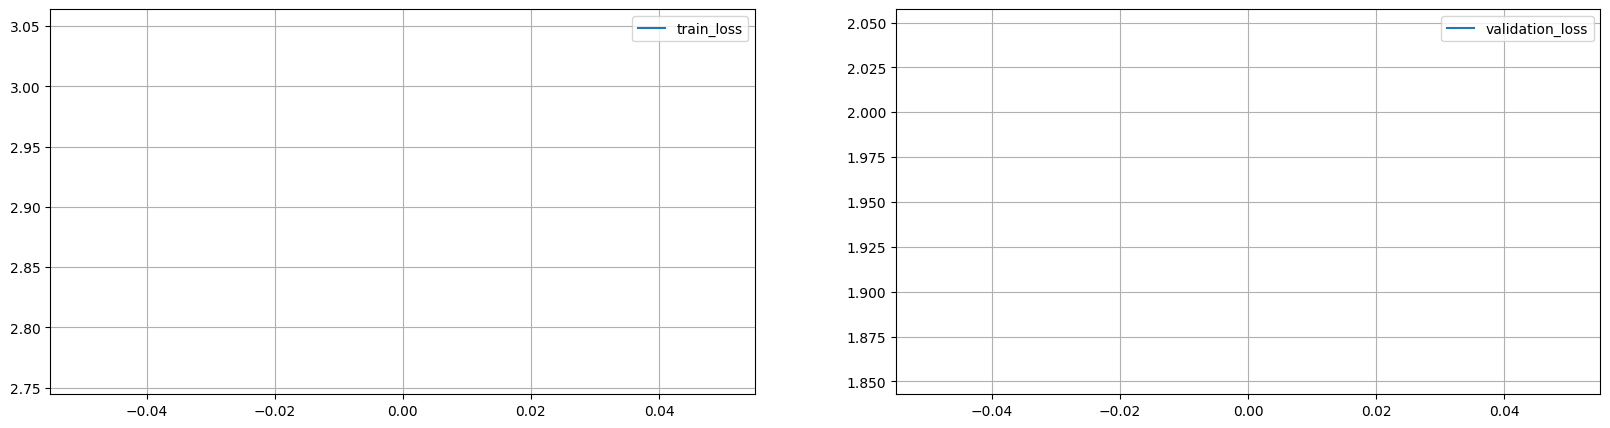

100%|██████████| 38/38 [00:08<00:00,  4.43it/s]


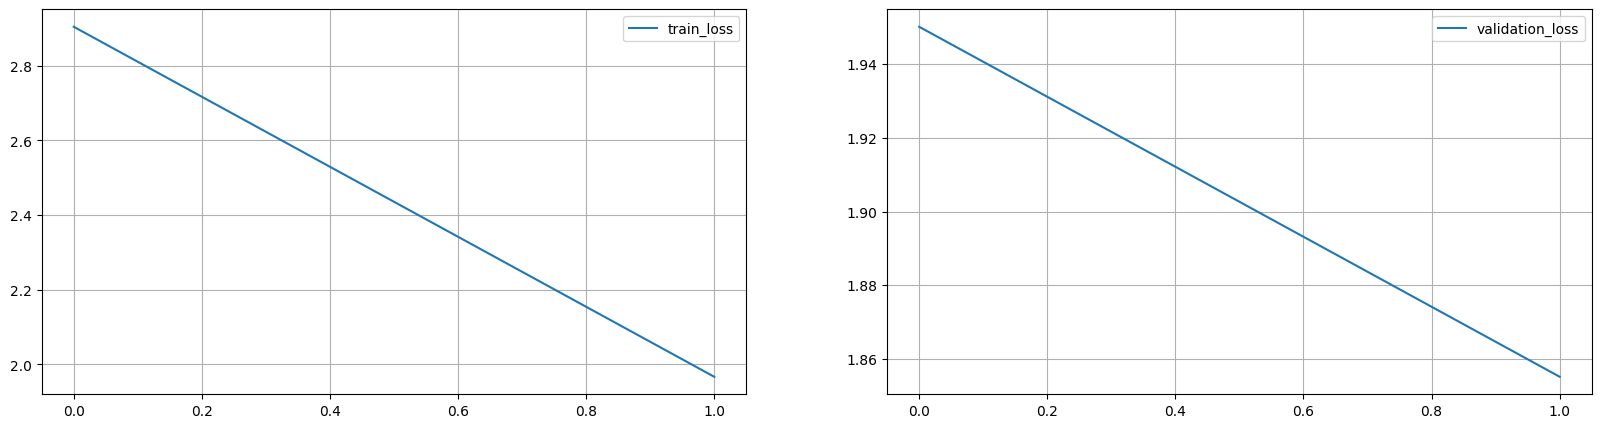

100%|██████████| 38/38 [00:08<00:00,  4.33it/s]


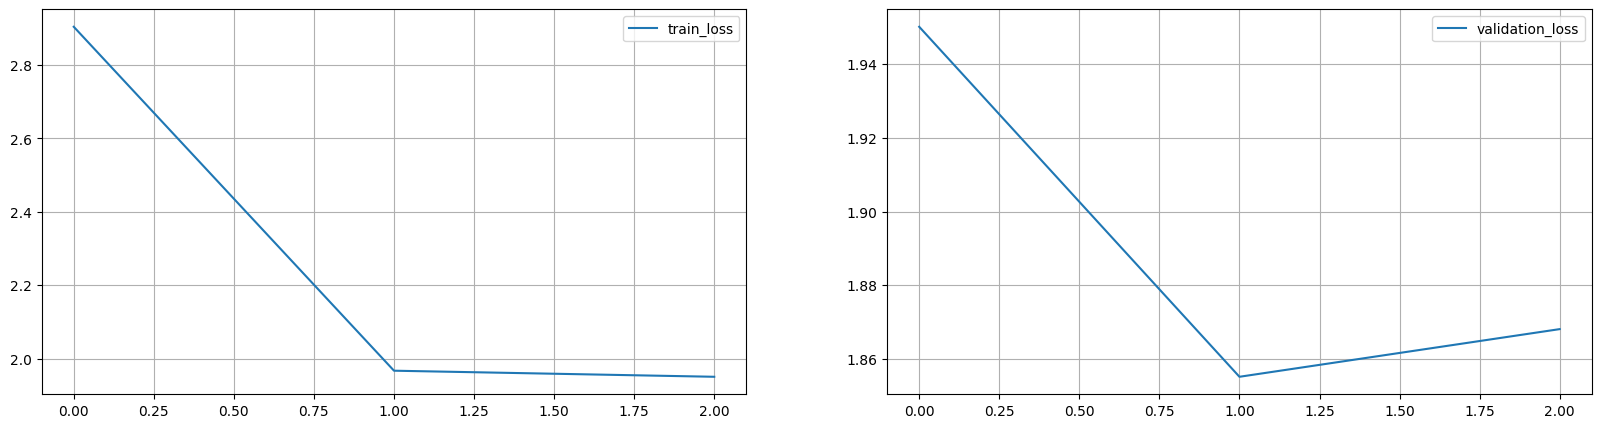

100%|██████████| 38/38 [00:08<00:00,  4.41it/s]


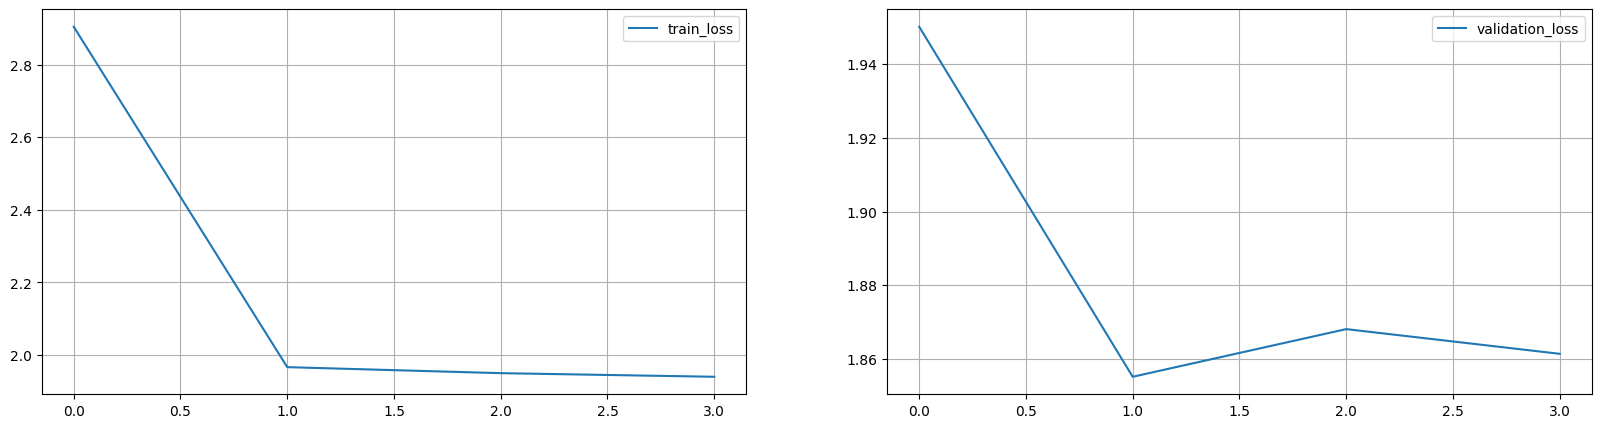

100%|██████████| 38/38 [00:08<00:00,  4.25it/s]


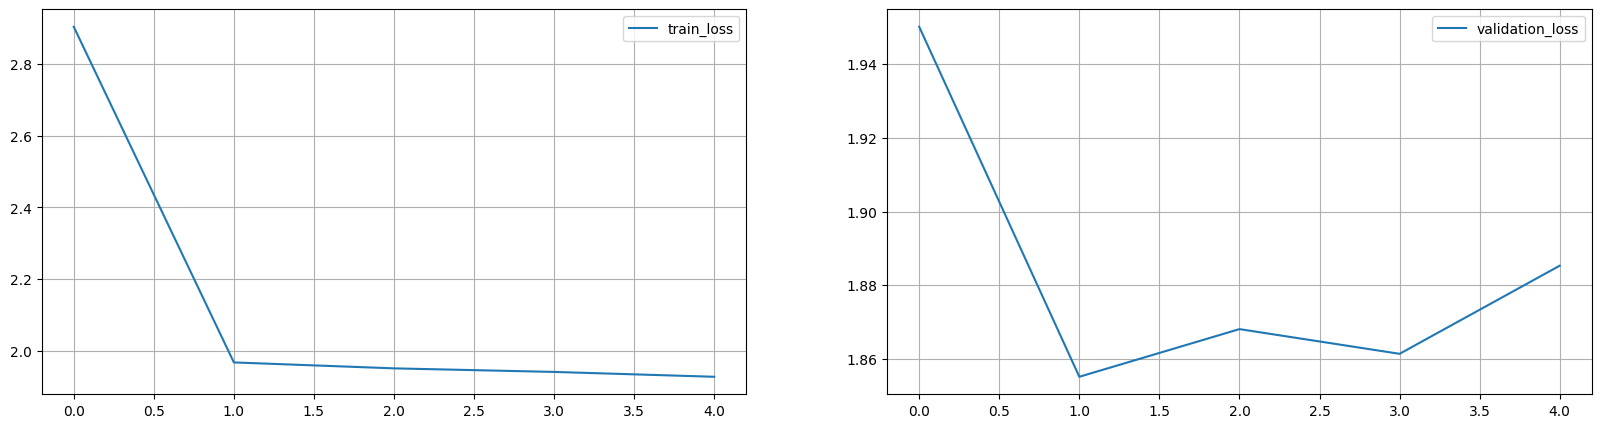

100%|██████████| 38/38 [00:08<00:00,  4.25it/s]


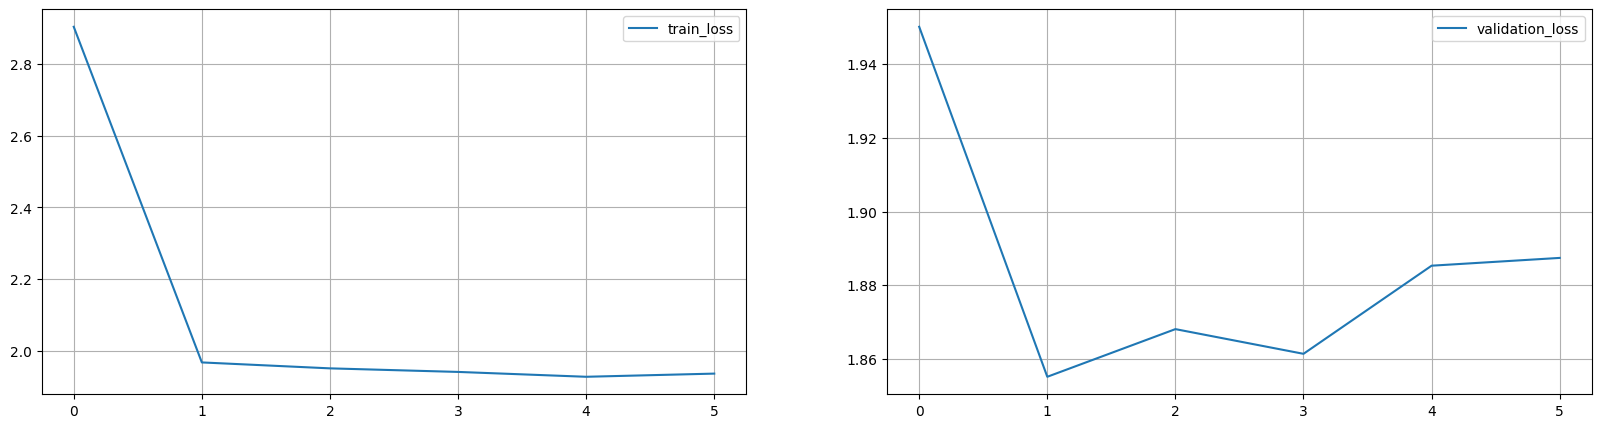

100%|██████████| 38/38 [00:08<00:00,  4.25it/s]


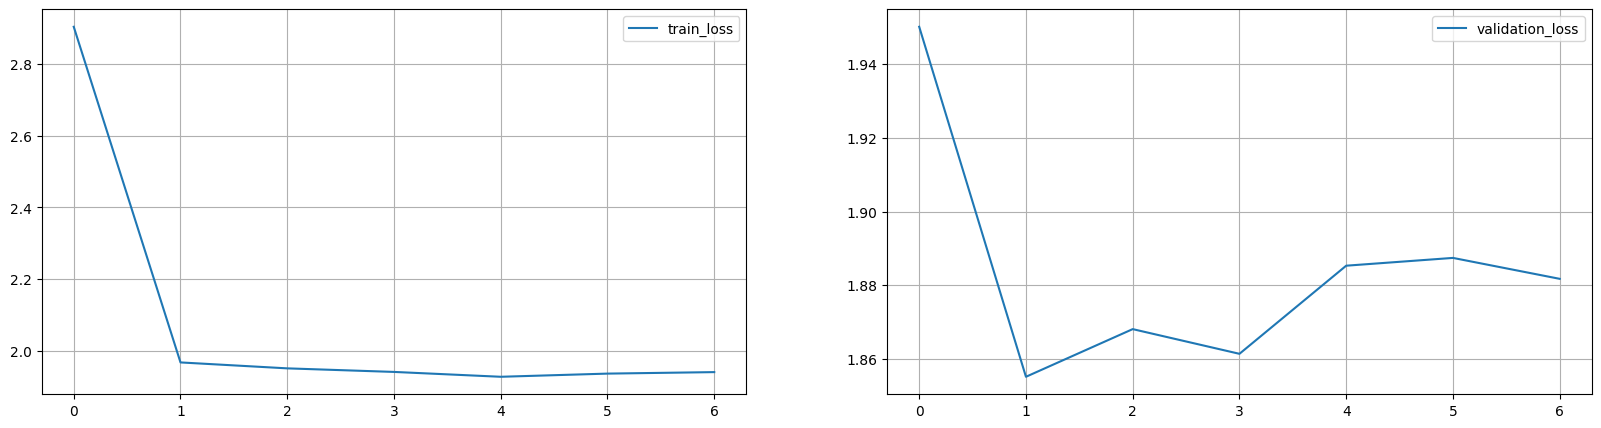

  0%|          | 0/338 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [12]:
storage = defaultdict(list)
num_epoch = 10

for epoch in range(num_epoch):
    train_loss_meter = AverageMeter()

    model.train()
    for i, batch in enumerate(pbar := tqdm(train_dataloader)):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device)
        length = batch['length'].to(device)
        targets = batch['targets'].to(device)
        target_lengths = batch['target_lengths'].to(device)

        mel, mel_length = featurizer(wav, length)
        mel = torch.swapaxes(mel, 1, 2)
        
        outputs, output_lengths = model(mel, mel_length)
        
        loss = criterion(outputs.transpose(0, 1), targets, output_lengths, target_lengths)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"loss: {loss.item():.5}")
        
        if loss > 0 and loss  < 1000:
            train_loss_meter.update(loss.item())
#         gc.collect()

    storage['train_loss'].append(train_loss_meter.avg)

    validation_loss_meter = AverageMeter()
    validation_accuracy_meter = AverageMeter()

    model.eval()
    for i, batch in enumerate(tqdm(validation_dataloader)):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device)
        length = batch['length'].to(device)
        targets = batch['targets'].to(device)
        target_lengths = batch['target_lengths'].to(device)

        with torch.no_grad():
            mel, mel_length = featurizer(wav, length)
            mel = torch.swapaxes(mel, 1, 2)
        
            outputs, output_lengths = model(mel, mel_length)
            loss = criterion(outputs.transpose(0, 1), targets, output_lengths, target_lengths)
            

#         matches = (outputs.argmax(dim=-1) == targets).float().mean()
        
        if loss > 0 and loss  < 1000:
            validation_loss_meter.update(loss.item())
#         validation_accuracy_meter.update(matches.item())
#         gc.collect()

    storage['validation_loss'].append(validation_loss_meter.avg)
#     storage['validation_accuracy'].append(validation_accuracy_meter.avg)


    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].plot(storage['train_loss'], label='train_loss')
    axes[1].plot(storage['validation_loss'], label='validation_loss')

#     axes[2].plot(storage['validation_accuracy'], label='validation_accuracy')

    for i in range(2):
        axes[i].grid()
        axes[i].legend()

    plt.show()

In [13]:
storage['train_loss']

[2.9042535162553555,
 1.9668516835028476,
 1.950295575936877,
 1.9403282626554734,
 1.9267752478580649,
 1.9356254740822605,
 1.9397948316427378]

In [ ]:
from src.data.free_spoken_digits import Featurizer 

In [15]:
from torchvision.transforms import Normalize
class NormalizedSpectrogram(torch.nn.Module):
    def __init__(self, normalize=None, *args, **kwargs):
        super(NormalizedSpectrogram, self).__init__(*args, **kwargs)
        if normalize == 'to05':
            self.normalize = Normalize([0.5], [0.5])
        elif normalize == 'touniform':
            self.normalize = lambda x: (x - torch.mean(x, dim=1, keepdim=True)) / (torch.std(x, dim=1, keepdim=True) + 1e-18)
        else:
            self.normalize = None


    def forward(self, melsec):
        if self.normalize is not None:
            logmelsec = torch.log(torch.clamp(melsec, min=1e-18))
            melsec = self.normalize(logmelsec[None])[0]
        return melsec

In [16]:
featurizer = Featurizer().to(device)

In [17]:
mel, mel_length = featurizer(wav, length)

/home/user/grandeur/notebooks/../src/data/free_spoken_digits.py:100: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  length = (length - self.featurizer.win_length) // self.featurizer.hop_length


In [18]:
mel.shape

torch.Size([16, 64, 18])

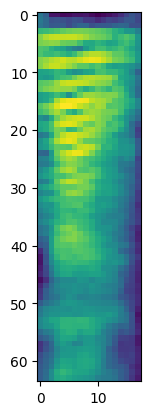

In [20]:
plt.imshow(mel[0].cpu().numpy())

In [55]:
normalize = lambda x: (x - torch.mean(x, dim=0, keepdim=True)) / (torch.std(x, dim=0, keepdim=True) + 1e-18)

In [56]:
mel1 = normalize(mel.cpu()).cpu()

In [40]:
mel2 = normalize(mel.cpu()).cpu()

In [58]:
mel.cpu().shape

torch.Size([16, 64, 18])

In [38]:
mel_log.min()

tensor(-41.4465, device='cuda:0')

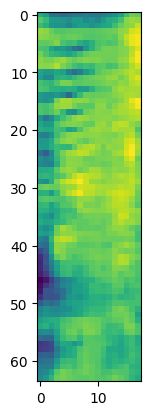

In [57]:
plt.imshow(mel1.numpy()[0])

In [61]:
mel1.min()

tensor(-2.7444)

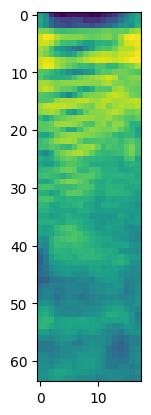

In [49]:
plt.imshow(mel2.numpy()[0])

In [20]:
target_lengths

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

In [19]:
outputs.shape

torch.Size([16, 16, 10])

In [14]:
from IPython import display

def inference(dataloader, take_n=10):
    batch = next(iter(dataloader))
    wav = batch['wav'].to(device, non_blocking=True)[:take_n]
    length = batch['length'].to(device, non_blocking=True)[:take_n]
    targets = batch['targets'].to(device, non_blocking=True)[:take_n]
    target_lengths = batch['target_lengths'].to(device, non_blocking=True)[:take_n]
    
    
    mel_inputs, mel_length = featurizer(wav, length)
    mel_inputs = torch.swapaxes(mel_inputs, 1, 2)
    outputs, output_lengths = model(mel_inputs, mel_length)
    classes = outputs.argmax(dim=-1)[:, 0]
    
    for i in range(take_n):
        display.display(display.Audio(data=wav[i].cpu().numpy(), rate=8000))
        print(classes[i], targets[i])
    

In [16]:
inference(train_dataloader, take_n=5)

tensor(4, device='cuda:0') tensor(1, device='cuda:0')


tensor(4, device='cuda:0') tensor(0, device='cuda:0')


tensor(4, device='cuda:0') tensor(0, device='cuda:0')


tensor(4, device='cuda:0') tensor(9, device='cuda:0')


tensor(4, device='cuda:0') tensor(2, device='cuda:0')


In [ ]:
# model

In [ ]:
# model_path = project_root()/"ckpt/free_spoken_digits.ckpt"

In [ ]:
# torch.save(model.eval(), model_path)

In [ ]:
# loaded_model = torch.load(model_path, map_location=torch.device("cpu"))

In [ ]:
# loaded_model